# Second Competition: Modulation format classification

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py

#import library
#from dnn_util import *

Load datasets. They are stored as a pickle file.

The datasets are taken from https://www.deepsig.io/datasets (RML2016.10a.tar.bz2), which contains a variety of radio datasets that are available as open datasets. The (simplified and modified, already pre-processed) dataset contains traces of 128 complex samples (Inphase and Quadrature component) of received radio signals with different modulation formats and at different signal-to-noise ratios (SNRs). The goal is to estimate the modulation format and/or the SNR from the traces.

In [166]:
# Load training dataset
with open('Deepsig_dataset_train.pkl', "rb") as f:
    X_train = pickle.load(f)
    y_train = pickle.load(f)
    SNR_train = pickle.load(f)
    modulation_formats = pickle.load(f)
    
# Load validation dataset
with open('Deepsig_dataset_valid.pkl', "rb") as f:
    X_valid = pickle.load(f)
    y_valid = pickle.load(f)
    SNR_valid = pickle.load(f)    

Print modulation formats that are used:

In [167]:
print('Modulation formats: ', modulation_formats)

Modulation formats:  ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `y_train` and the corresponding SNR is given in `SNR_train`. The label in `y_train` corresponds to one of the modulation formats in `modulation_formats`.

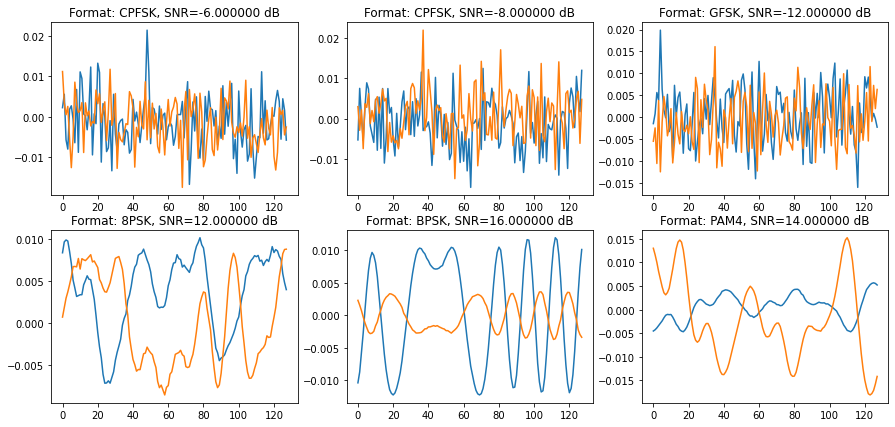

In [168]:
# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train[k+starti,:]))
    plt.plot(np.imag(X_train[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train[k+starti]], SNR_train[k+starti]))

## Task 1: Distinguish between BPSK and GFSK
You are given samples of an unknown modulation format and your task is to determine the modulation format in order to setup the receiver correctly. Try the following two options:
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

Show the classification error for the validation set for each SNR point separately.

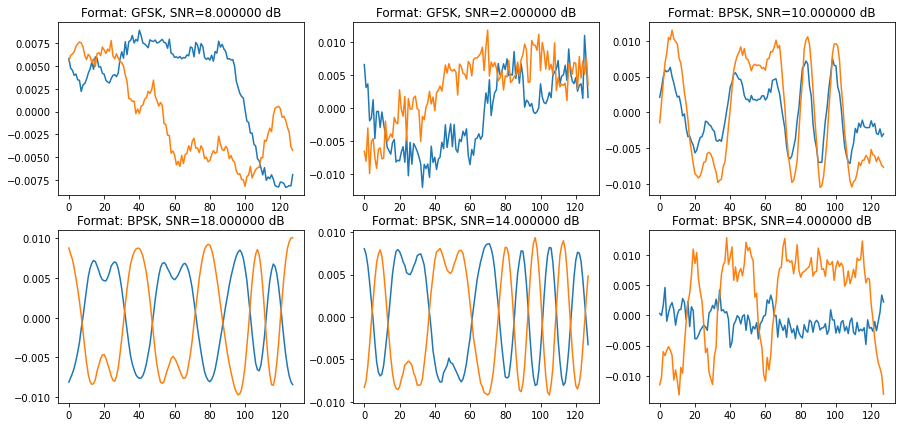

In [169]:
# generate Training set for Task 1
task1_modulation_formatidx = [i for i in range(len(modulation_formats)) if (modulation_formats[i] == 'BPSK' or modulation_formats[i] == 'GFSK')] 

task1_train_idx = [i for i in range(len(y_train)) if (y_train[i] == task1_modulation_formatidx[0] or y_train[i] == task1_modulation_formatidx[1])]
y_train_task1 = y_train[task1_train_idx]
X_train_task1 = X_train[task1_train_idx,:]
SNR_train_task1 = SNR_train[task1_train_idx]

task1_valid_idx = [i for i in range(len(y_valid)) if (y_valid[i] == task1_modulation_formatidx[0] or y_valid[i] == task1_modulation_formatidx[1])]
y_valid_task1 = y_valid[task1_valid_idx]
X_valid_task1 = X_valid[task1_valid_idx,:]
SNR_valid_task1 = SNR_valid[task1_valid_idx]

# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train_task1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task1[k+starti,:]))
    plt.plot(np.imag(X_train_task1[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train_task1[k+starti]], SNR_train_task1[k+starti]))

In [176]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py

def sigmoid(Z):
    #sigmoid activation function 
    A = 1/(1+np.exp(-Z))
    cache = Z
    #return A and cache
    return A,cache

def relu(Z):
    #ReLu activation function
    A = np.maximum(0,Z)

    assert (A.shape == Z.shape)

    cache = Z
    return A, cache

def relu_backward(dA, cache):
    #backward propagation for relu activation function
    Z = cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

def sigmoid_backward(dA, cache):
    #backward propagation for sigmoid activation function
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ= dA * s * (1-s)
    assert (dZ.shape == Z.shape)

    return dZ

def initialize_parameters(n_x,n_h,n_y):
    #initialize parameters
    np.random.seed(1) #seed 1
    W1 = np.random.randn(n_h,n_x)*np.sqrt(2/n_x) #initialize with he initialization
    b1 = np.zeros((n_h,1))                       #zero initialization
    W2 = np.random.randn(n_y,n_h)*np.sqrt(2/n_h) #
    b2 = np.zeros((n_y,1))
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))

    parameters = {"W1":W1,"b1":b1,"W2":W2,"b2":b2,}

    return parameters

def initialize_parameters_deep(layer_dims):
    #initialize parameters for deep learning neural network
    #layer_dim is an array contain the dimension of each layer in network
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

def linear_forward(A,W,b):
    #the linear part of the layer propagation network
    Z = W.dot(A) + b
    assert(Z.shape == (W.shape[0],A.shape[1]))
    cache = (A,W,b)

    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    #implement the forward propagation for the linear activation
    if activation =="sigmoid":
        Z, lin_cache = linear_forward(A_prev, W, b)
        A, act_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, lin_cache = linear_forward(A_prev, W, b)
        A, act_cache = relu(Z)

    assert (A.shape == (W.shape[0],A_prev.shape[1]))
    cache = (lin_cache, act_cache)

    return A, cache

def L_model_forward(X, parameters):
    #implement forward propagation for the linear relu and linear relu 

    caches = []
    A = X
    L = len(parameters)//2
    #loop over the neural network layers
    for l in range(1,L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters['W' + str(l)], parameters['b' + str(l)],
                                            activation = "relu")
        caches.append(cache)
    
    #implement linear sigmoid activation for the last layer
    AL, cache = linear_activation_forward(A,parameters['W' + str(L)], parameters['b' + str(L)], 
                                        activation = "sigmoid")
    caches.append(cache)

    assert(AL.shape == (1,X.shape[1]))

    return AL,caches

def compute_cost(AL,Y):
    #calculate cost function
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      
    assert(cost.shape == ())

    return cost

def linear_backward(dZ, cache):
    #implement a linear portion of backward prop for single layer
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    #implement the backward prop 
    lin_cache, act_cache = cache

    if activation == "relu":        
        dZ = relu_backward(dA, act_cache)
        dA_prev, dW, db = linear_backward(dZ, lin_cache)
    
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, act_cache)
        dA_prev, dW, db = linear_backward(dZ, lin_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    #implement a linear backward propagation for linear relu and linear sigmoid
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads



def update_parameters(parameters, grads, learning_rate):
    #update the parameters using gradient descent
    L = len(parameters) // 2
    #update rule for each parameter
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    
    return parameters


def deep_network_model(X,Y,layer_dims,learning_rate=0.01,num_iter=2500,print_cost=False):
    #implementation of multiple layer neural network

    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layer_dims)

    #loop over to calculate gradient descent
    for i in range(0, num_iter):
        #forward propagation
        AL, caches = L_model_forward(X,parameters)

        #calculate the cost
        cost = compute_cost(AL,Y)

        #Backward Propagation
        grads = L_model_backward(AL,Y,caches)

        #update parameters
        parameters = update_parameters(parameters,grads,learning_rate)

        #print cost every 100th examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    #plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

# helper function to compute the classification error rate
def CER(predictions, labels):
    return (np.sum(predictions != labels) / np.size(predictions))

#function to predict output from input and neural network parameters
def make_prediction(X,params):
    m = X.shape[1]
    p = np.zeros((1,m))
    A2,cache = L_model_forward(X,params)
    
    for i in range(0,A2.shape[1]):
        if A2[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    return p




Cost after iteration 0: 0.693187
Cost after iteration 100: 0.691752
Cost after iteration 200: 0.691281
Cost after iteration 300: 0.690705
Cost after iteration 400: 0.689939
Cost after iteration 500: 0.688799
Cost after iteration 600: 0.687062
Cost after iteration 700: 0.684217
Cost after iteration 800: 0.679031
Cost after iteration 900: 0.668611
Cost after iteration 1000: 0.644939
Cost after iteration 1100: 0.592229
Cost after iteration 1200: 0.510273
Cost after iteration 1300: 0.511897
Cost after iteration 1400: 0.464768
Cost after iteration 1500: 0.426976
Cost after iteration 1600: 0.317969
Cost after iteration 1700: 0.502095
Cost after iteration 1800: 0.170184
Cost after iteration 1900: 0.030251
Cost after iteration 2000: 0.015399
Cost after iteration 2100: 0.009544
Cost after iteration 2200: 0.006641
Cost after iteration 2300: 0.004969
Cost after iteration 2400: 0.003908
Cost after iteration 2500: 0.003184
Cost after iteration 2600: 0.002666
Cost after iteration 2700: 0.002279
Cost

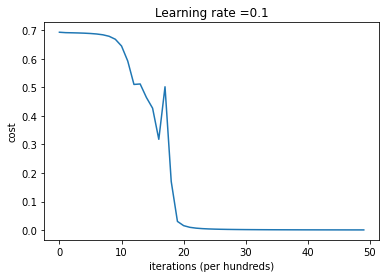

Erorr rate for training set ,SNR -20 dB = 0.0
Error rate for validation set ,SNR -20 dB = 0.5229357798165137
Cost after iteration 0: 0.692713
Cost after iteration 100: 0.691828
Cost after iteration 200: 0.691049
Cost after iteration 300: 0.690063
Cost after iteration 400: 0.688544
Cost after iteration 500: 0.686188
Cost after iteration 600: 0.681907
Cost after iteration 700: 0.673652
Cost after iteration 800: 0.656603
Cost after iteration 900: 0.621814
Cost after iteration 1000: 0.566259
Cost after iteration 1100: 0.528551
Cost after iteration 1200: 0.510670
Cost after iteration 1300: 0.474245
Cost after iteration 1400: 0.423703
Cost after iteration 1500: 0.402372
Cost after iteration 1600: 0.136108
Cost after iteration 1700: 0.051683
Cost after iteration 1800: 0.024430
Cost after iteration 1900: 0.012669
Cost after iteration 2000: 0.008238
Cost after iteration 2100: 0.005914
Cost after iteration 2200: 0.004521
Cost after iteration 2300: 0.003610
Cost after iteration 2400: 0.002976
Cos

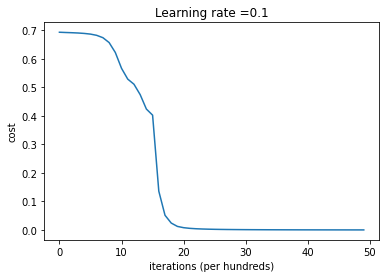

Erorr rate for training set ,SNR -18 dB = 0.0
Error rate for validation set ,SNR -18 dB = 0.5341246290801187
Cost after iteration 0: 0.693626
Cost after iteration 100: 0.692939
Cost after iteration 200: 0.692723
Cost after iteration 300: 0.692539
Cost after iteration 400: 0.692342
Cost after iteration 500: 0.692120
Cost after iteration 600: 0.691842
Cost after iteration 700: 0.691479
Cost after iteration 800: 0.691026
Cost after iteration 900: 0.690441
Cost after iteration 1000: 0.689620
Cost after iteration 1100: 0.688428
Cost after iteration 1200: 0.686400
Cost after iteration 1300: 0.682908
Cost after iteration 1400: 0.676512
Cost after iteration 1500: 0.663907
Cost after iteration 1600: 0.639068
Cost after iteration 1700: 0.592626
Cost after iteration 1800: 0.522677
Cost after iteration 1900: 0.524778
Cost after iteration 2000: 0.489749
Cost after iteration 2100: 0.445230
Cost after iteration 2200: 0.404980
Cost after iteration 2300: 0.264970
Cost after iteration 2400: 0.061051
Cos

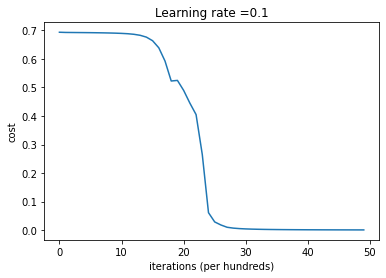

Erorr rate for training set ,SNR -16 dB = 0.0
Error rate for validation set ,SNR -16 dB = 0.5028409090909091
Cost after iteration 0: 0.693197
Cost after iteration 100: 0.692623
Cost after iteration 200: 0.692128
Cost after iteration 300: 0.691428
Cost after iteration 400: 0.690445
Cost after iteration 500: 0.689015
Cost after iteration 600: 0.686807
Cost after iteration 700: 0.682997
Cost after iteration 800: 0.675785
Cost after iteration 900: 0.660395
Cost after iteration 1000: 0.624893
Cost after iteration 1100: 0.557540
Cost after iteration 1200: 0.527334
Cost after iteration 1300: 0.493525
Cost after iteration 1400: 0.449634
Cost after iteration 1500: 0.419111
Cost after iteration 1600: 0.158071
Cost after iteration 1700: 0.068712
Cost after iteration 1800: 0.026257
Cost after iteration 1900: 0.014062
Cost after iteration 2000: 0.008949
Cost after iteration 2100: 0.006318
Cost after iteration 2200: 0.004773
Cost after iteration 2300: 0.003778
Cost after iteration 2400: 0.003094
Cos

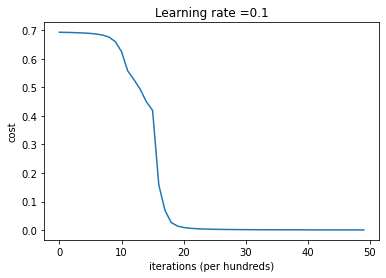

Erorr rate for training set ,SNR -14 dB = 0.0
Error rate for validation set ,SNR -14 dB = 0.4984126984126984
Cost after iteration 0: 0.693238
Cost after iteration 100: 0.692751
Cost after iteration 200: 0.692309
Cost after iteration 300: 0.691857
Cost after iteration 400: 0.691264
Cost after iteration 500: 0.690386
Cost after iteration 600: 0.689093
Cost after iteration 700: 0.687196
Cost after iteration 800: 0.684107
Cost after iteration 900: 0.678522
Cost after iteration 1000: 0.667305
Cost after iteration 1100: 0.643706
Cost after iteration 1200: 0.596890
Cost after iteration 1300: 0.523076
Cost after iteration 1400: 0.522153
Cost after iteration 1500: 0.494959
Cost after iteration 1600: 0.441978
Cost after iteration 1700: 0.486959
Cost after iteration 1800: 0.299238
Cost after iteration 1900: 0.084355
Cost after iteration 2000: 0.041937
Cost after iteration 2100: 0.019896
Cost after iteration 2200: 0.011289
Cost after iteration 2300: 0.007591
Cost after iteration 2400: 0.005564
Cos

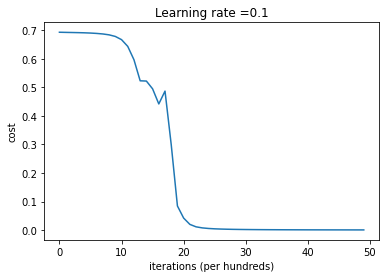

Erorr rate for training set ,SNR -12 dB = 0.0
Error rate for validation set ,SNR -12 dB = 0.5339506172839507
Cost after iteration 0: 0.692903
Cost after iteration 100: 0.692159
Cost after iteration 200: 0.691653
Cost after iteration 300: 0.690925
Cost after iteration 400: 0.689572
Cost after iteration 500: 0.687604
Cost after iteration 600: 0.684469
Cost after iteration 700: 0.678981
Cost after iteration 800: 0.668316
Cost after iteration 900: 0.645997
Cost after iteration 1000: 0.599816
Cost after iteration 1100: 0.520071
Cost after iteration 1200: 0.526484
Cost after iteration 1300: 0.482352
Cost after iteration 1400: 0.448695
Cost after iteration 1500: 0.331301
Cost after iteration 1600: 0.135556
Cost after iteration 1700: 0.056149
Cost after iteration 1800: 0.026460
Cost after iteration 1900: 0.013673
Cost after iteration 2000: 0.008568
Cost after iteration 2100: 0.006088
Cost after iteration 2200: 0.004627
Cost after iteration 2300: 0.003680
Cost after iteration 2400: 0.003025
Cos

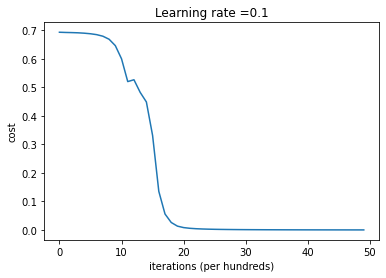

Erorr rate for training set ,SNR -10 dB = 0.0
Error rate for validation set ,SNR -10 dB = 0.4785276073619632
Cost after iteration 0: 0.693295
Cost after iteration 100: 0.692617
Cost after iteration 200: 0.692218
Cost after iteration 300: 0.691786
Cost after iteration 400: 0.691243
Cost after iteration 500: 0.690437
Cost after iteration 600: 0.689221
Cost after iteration 700: 0.687475
Cost after iteration 800: 0.684714
Cost after iteration 900: 0.679931
Cost after iteration 1000: 0.670912
Cost after iteration 1100: 0.652448
Cost after iteration 1200: 0.613682
Cost after iteration 1300: 0.543807
Cost after iteration 1400: 0.521935
Cost after iteration 1500: 0.485924
Cost after iteration 1600: 0.440265
Cost after iteration 1700: 0.425380
Cost after iteration 1800: 0.187967
Cost after iteration 1900: 0.045917
Cost after iteration 2000: 0.020600
Cost after iteration 2100: 0.011891
Cost after iteration 2200: 0.007918
Cost after iteration 2300: 0.005758
Cost after iteration 2400: 0.004438
Cos

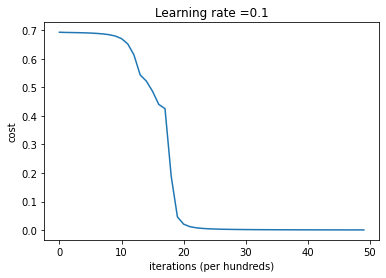

Erorr rate for training set ,SNR -8 dB = 0.0
Error rate for validation set ,SNR -8 dB = 0.403030303030303
Cost after iteration 0: 0.693499
Cost after iteration 100: 0.692491
Cost after iteration 200: 0.692015
Cost after iteration 300: 0.691477
Cost after iteration 400: 0.690863
Cost after iteration 500: 0.690069
Cost after iteration 600: 0.688953
Cost after iteration 700: 0.687250
Cost after iteration 800: 0.684453
Cost after iteration 900: 0.679706
Cost after iteration 1000: 0.670522
Cost after iteration 1100: 0.650922
Cost after iteration 1200: 0.603745
Cost after iteration 1300: 0.484298
Cost after iteration 1400: 0.436167
Cost after iteration 1500: 0.316027
Cost after iteration 1600: 0.086677
Cost after iteration 1700: 0.032752
Cost after iteration 1800: 0.016431
Cost after iteration 1900: 0.010039
Cost after iteration 2000: 0.006905
Cost after iteration 2100: 0.005123
Cost after iteration 2200: 0.004002
Cost after iteration 2300: 0.003245
Cost after iteration 2400: 0.002706
Cost a

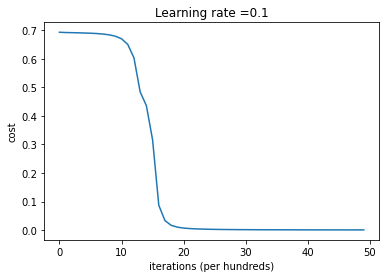

Erorr rate for training set ,SNR -6 dB = 0.0
Error rate for validation set ,SNR -6 dB = 0.34782608695652173
Cost after iteration 0: 0.693349
Cost after iteration 100: 0.692249
Cost after iteration 200: 0.691749
Cost after iteration 300: 0.691199
Cost after iteration 400: 0.690454
Cost after iteration 500: 0.689331
Cost after iteration 600: 0.687550
Cost after iteration 700: 0.684368
Cost after iteration 800: 0.678241
Cost after iteration 900: 0.664859
Cost after iteration 1000: 0.630059
Cost after iteration 1100: 0.526463
Cost after iteration 1200: 0.373063
Cost after iteration 1300: 0.179166
Cost after iteration 1400: 0.048279
Cost after iteration 1500: 0.021839
Cost after iteration 1600: 0.012341
Cost after iteration 1700: 0.008054
Cost after iteration 1800: 0.005764
Cost after iteration 1900: 0.004389
Cost after iteration 2000: 0.003490
Cost after iteration 2100: 0.002866
Cost after iteration 2200: 0.002412
Cost after iteration 2300: 0.002070
Cost after iteration 2400: 0.001804
Cost

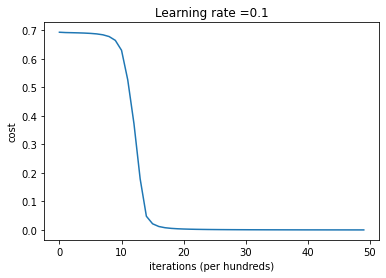

Erorr rate for training set ,SNR -4 dB = 0.0
Error rate for validation set ,SNR -4 dB = 0.25149700598802394
Cost after iteration 0: 0.693336
Cost after iteration 100: 0.691776
Cost after iteration 200: 0.690161
Cost after iteration 300: 0.687520
Cost after iteration 400: 0.682312
Cost after iteration 500: 0.669756
Cost after iteration 600: 0.629153
Cost after iteration 700: 0.458715
Cost after iteration 800: 0.231725
Cost after iteration 900: 0.070919
Cost after iteration 1000: 0.029460
Cost after iteration 1100: 0.015372
Cost after iteration 1200: 0.009479
Cost after iteration 1300: 0.006533
Cost after iteration 1400: 0.004843
Cost after iteration 1500: 0.003776
Cost after iteration 1600: 0.003056
Cost after iteration 1700: 0.002543
Cost after iteration 1800: 0.002163
Cost after iteration 1900: 0.001871
Cost after iteration 2000: 0.001641
Cost after iteration 2100: 0.001457
Cost after iteration 2200: 0.001306
Cost after iteration 2300: 0.001181
Cost after iteration 2400: 0.001075
Cost

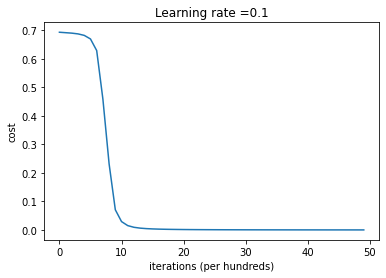

Erorr rate for training set ,SNR -2 dB = 0.0
Error rate for validation set ,SNR -2 dB = 0.30745341614906835
Cost after iteration 0: 0.693590
Cost after iteration 100: 0.691537
Cost after iteration 200: 0.689443
Cost after iteration 300: 0.685431
Cost after iteration 400: 0.675485
Cost after iteration 500: 0.642101
Cost after iteration 600: 0.482493
Cost after iteration 700: 0.186494
Cost after iteration 800: 0.073447
Cost after iteration 900: 0.033847
Cost after iteration 1000: 0.017358
Cost after iteration 1100: 0.010422
Cost after iteration 1200: 0.007058
Cost after iteration 1300: 0.005169
Cost after iteration 1400: 0.003995
Cost after iteration 1500: 0.003209
Cost after iteration 1600: 0.002655
Cost after iteration 1700: 0.002247
Cost after iteration 1800: 0.001938
Cost after iteration 1900: 0.001695
Cost after iteration 2000: 0.001501
Cost after iteration 2100: 0.001342
Cost after iteration 2200: 0.001211
Cost after iteration 2300: 0.001100
Cost after iteration 2400: 0.001006
Cost

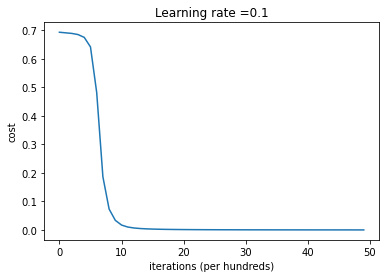

Erorr rate for training set ,SNR 0 dB = 0.0
Error rate for validation set ,SNR 0 dB = 0.35517241379310344
Cost after iteration 0: 0.693326
Cost after iteration 100: 0.690338
Cost after iteration 200: 0.685448
Cost after iteration 300: 0.673547
Cost after iteration 400: 0.631580
Cost after iteration 500: 0.430435
Cost after iteration 600: 0.147084
Cost after iteration 700: 0.060351
Cost after iteration 800: 0.028409
Cost after iteration 900: 0.015155
Cost after iteration 1000: 0.009489
Cost after iteration 1100: 0.006593
Cost after iteration 1200: 0.004906
Cost after iteration 1300: 0.003833
Cost after iteration 1400: 0.003104
Cost after iteration 1500: 0.002584
Cost after iteration 1600: 0.002197
Cost after iteration 1700: 0.001900
Cost after iteration 1800: 0.001667
Cost after iteration 1900: 0.001479
Cost after iteration 2000: 0.001325
Cost after iteration 2100: 0.001198
Cost after iteration 2200: 0.001090
Cost after iteration 2300: 0.000998
Cost after iteration 2400: 0.000919
Cost a

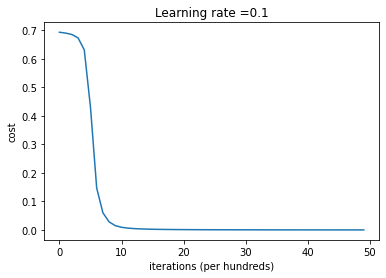

Erorr rate for training set ,SNR 2 dB = 0.0
Error rate for validation set ,SNR 2 dB = 0.19344262295081968
Cost after iteration 0: 0.693265
Cost after iteration 100: 0.690268
Cost after iteration 200: 0.685703
Cost after iteration 300: 0.673978
Cost after iteration 400: 0.632219
Cost after iteration 500: 0.438988
Cost after iteration 600: 0.162077
Cost after iteration 700: 0.067222
Cost after iteration 800: 0.032367
Cost after iteration 900: 0.017993
Cost after iteration 1000: 0.011383
Cost after iteration 1100: 0.007905
Cost after iteration 1200: 0.005868
Cost after iteration 1300: 0.004571
Cost after iteration 1400: 0.003690
Cost after iteration 1500: 0.003063
Cost after iteration 1600: 0.002598
Cost after iteration 1700: 0.002242
Cost after iteration 1800: 0.001962
Cost after iteration 1900: 0.001737
Cost after iteration 2000: 0.001554
Cost after iteration 2100: 0.001401
Cost after iteration 2200: 0.001273
Cost after iteration 2300: 0.001164
Cost after iteration 2400: 0.001070
Cost a

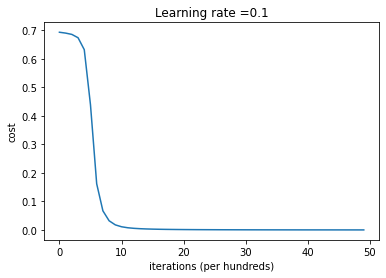

Erorr rate for training set ,SNR 4 dB = 0.0
Error rate for validation set ,SNR 4 dB = 0.23548387096774193
Cost after iteration 0: 0.693419
Cost after iteration 100: 0.690421
Cost after iteration 200: 0.686566
Cost after iteration 300: 0.677842
Cost after iteration 400: 0.649454
Cost after iteration 500: 0.518110
Cost after iteration 600: 0.196605
Cost after iteration 700: 0.065268
Cost after iteration 800: 0.030100
Cost after iteration 900: 0.017071
Cost after iteration 1000: 0.011035
Cost after iteration 1100: 0.007794
Cost after iteration 1200: 0.005858
Cost after iteration 1300: 0.004604
Cost after iteration 1400: 0.003741
Cost after iteration 1500: 0.003118
Cost after iteration 1600: 0.002653
Cost after iteration 1700: 0.002294
Cost after iteration 1800: 0.002012
Cost after iteration 1900: 0.001785
Cost after iteration 2000: 0.001598
Cost after iteration 2100: 0.001443
Cost after iteration 2200: 0.001313
Cost after iteration 2300: 0.001201
Cost after iteration 2400: 0.001106
Cost a

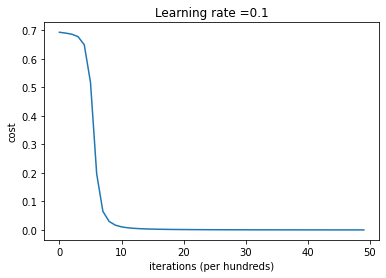

Erorr rate for training set ,SNR 6 dB = 0.0
Error rate for validation set ,SNR 6 dB = 0.008982035928143712
Cost after iteration 0: 0.693510
Cost after iteration 100: 0.689700
Cost after iteration 200: 0.683439
Cost after iteration 300: 0.666533
Cost after iteration 400: 0.601469
Cost after iteration 500: 0.318888
Cost after iteration 600: 0.101798
Cost after iteration 700: 0.046698
Cost after iteration 800: 0.026786
Cost after iteration 900: 0.018172
Cost after iteration 1000: 0.013832
Cost after iteration 1100: 0.011352
Cost after iteration 1200: 0.009766
Cost after iteration 1300: 0.008125
Cost after iteration 1400: 0.005264
Cost after iteration 1500: 0.004049
Cost after iteration 1600: 0.003305
Cost after iteration 1700: 0.002774
Cost after iteration 1800: 0.002377
Cost after iteration 1900: 0.002070
Cost after iteration 2000: 0.001826
Cost after iteration 2100: 0.001628
Cost after iteration 2200: 0.001465
Cost after iteration 2300: 0.001329
Cost after iteration 2400: 0.001213
Cost 

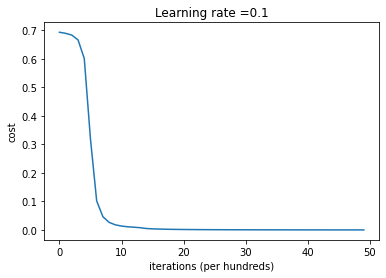

Erorr rate for training set ,SNR 8 dB = 0.0
Error rate for validation set ,SNR 8 dB = 0.06430868167202572
Cost after iteration 0: 0.693865
Cost after iteration 100: 0.690957
Cost after iteration 200: 0.687416
Cost after iteration 300: 0.679878
Cost after iteration 400: 0.656027
Cost after iteration 500: 0.536214
Cost after iteration 600: 0.196614
Cost after iteration 700: 0.075001
Cost after iteration 800: 0.035216
Cost after iteration 900: 0.019491
Cost after iteration 1000: 0.012257
Cost after iteration 1100: 0.008454
Cost after iteration 1200: 0.006238
Cost after iteration 1300: 0.004835
Cost after iteration 1400: 0.003886
Cost after iteration 1500: 0.003211
Cost after iteration 1600: 0.002713
Cost after iteration 1700: 0.002334
Cost after iteration 1800: 0.002038
Cost after iteration 1900: 0.001800
Cost after iteration 2000: 0.001607
Cost after iteration 2100: 0.001448
Cost after iteration 2200: 0.001314
Cost after iteration 2300: 0.001200
Cost after iteration 2400: 0.001103
Cost a

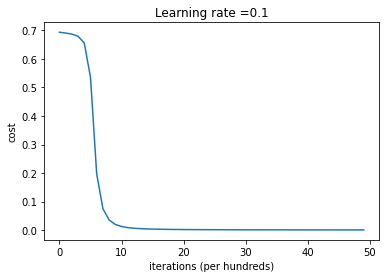

Erorr rate for training set ,SNR 10 dB = 0.0
Error rate for validation set ,SNR 10 dB = 0.06153846153846154
Cost after iteration 0: 0.693338
Cost after iteration 100: 0.689932
Cost after iteration 200: 0.685093
Cost after iteration 300: 0.673291
Cost after iteration 400: 0.632707
Cost after iteration 500: 0.436652
Cost after iteration 600: 0.129927
Cost after iteration 700: 0.049130
Cost after iteration 800: 0.024876
Cost after iteration 900: 0.014860
Cost after iteration 1000: 0.009892
Cost after iteration 1100: 0.007126
Cost after iteration 1200: 0.005428
Cost after iteration 1300: 0.004310
Cost after iteration 1400: 0.003517
Cost after iteration 1500: 0.002942
Cost after iteration 1600: 0.002512
Cost after iteration 1700: 0.002181
Cost after iteration 1800: 0.001918
Cost after iteration 1900: 0.001705
Cost after iteration 2000: 0.001531
Cost after iteration 2100: 0.001386
Cost after iteration 2200: 0.001263
Cost after iteration 2300: 0.001158
Cost after iteration 2400: 0.001067
Cost

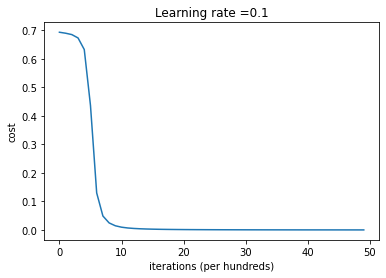

Erorr rate for training set ,SNR 12 dB = 0.0
Error rate for validation set ,SNR 12 dB = 0.015384615384615385
Cost after iteration 0: 0.693488
Cost after iteration 100: 0.689948
Cost after iteration 200: 0.685015
Cost after iteration 300: 0.671962
Cost after iteration 400: 0.618422
Cost after iteration 500: 0.352997
Cost after iteration 600: 0.109103
Cost after iteration 700: 0.045076
Cost after iteration 800: 0.023362
Cost after iteration 900: 0.013973
Cost after iteration 1000: 0.009222
Cost after iteration 1100: 0.006604
Cost after iteration 1200: 0.005011
Cost after iteration 1300: 0.003967
Cost after iteration 1400: 0.003243
Cost after iteration 1500: 0.002716
Cost after iteration 1600: 0.002320
Cost after iteration 1700: 0.002014
Cost after iteration 1800: 0.001771
Cost after iteration 1900: 0.001576
Cost after iteration 2000: 0.001415
Cost after iteration 2100: 0.001280
Cost after iteration 2200: 0.001166
Cost after iteration 2300: 0.001069
Cost after iteration 2400: 0.000985
Cos

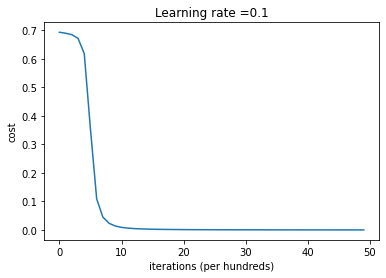

Erorr rate for training set ,SNR 14 dB = 0.0
Error rate for validation set ,SNR 14 dB = 0.06567164179104477
Cost after iteration 0: 0.693291
Cost after iteration 100: 0.690204
Cost after iteration 200: 0.685230
Cost after iteration 300: 0.672560
Cost after iteration 400: 0.622466
Cost after iteration 500: 0.360770
Cost after iteration 600: 0.117863
Cost after iteration 700: 0.050862
Cost after iteration 800: 0.026553
Cost after iteration 900: 0.016046
Cost after iteration 1000: 0.010745
Cost after iteration 1100: 0.007762
Cost after iteration 1200: 0.005906
Cost after iteration 1300: 0.004663
Cost after iteration 1400: 0.003797
Cost after iteration 1500: 0.003169
Cost after iteration 1600: 0.002698
Cost after iteration 1700: 0.002334
Cost after iteration 1800: 0.002047
Cost after iteration 1900: 0.001815
Cost after iteration 2000: 0.001625
Cost after iteration 2100: 0.001468
Cost after iteration 2200: 0.001335
Cost after iteration 2300: 0.001222
Cost after iteration 2400: 0.001124
Cost

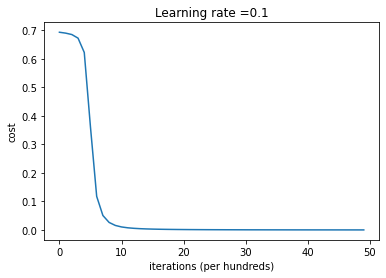

Erorr rate for training set ,SNR 16 dB = 0.0
Error rate for validation set ,SNR 16 dB = 0.04560260586319218
Cost after iteration 0: 0.693399
Cost after iteration 100: 0.690268
Cost after iteration 200: 0.685729
Cost after iteration 300: 0.675160
Cost after iteration 400: 0.642242
Cost after iteration 500: 0.491285
Cost after iteration 600: 0.176794
Cost after iteration 700: 0.060703
Cost after iteration 800: 0.028936
Cost after iteration 900: 0.016747
Cost after iteration 1000: 0.010959
Cost after iteration 1100: 0.007800
Cost after iteration 1200: 0.005889
Cost after iteration 1300: 0.004647
Cost after iteration 1400: 0.003788
Cost after iteration 1500: 0.003166
Cost after iteration 1600: 0.002698
Cost after iteration 1700: 0.002336
Cost after iteration 1800: 0.002050
Cost after iteration 1900: 0.001820
Cost after iteration 2000: 0.001631
Cost after iteration 2100: 0.001473
Cost after iteration 2200: 0.001340
Cost after iteration 2300: 0.001226
Cost after iteration 2400: 0.001128
Cost

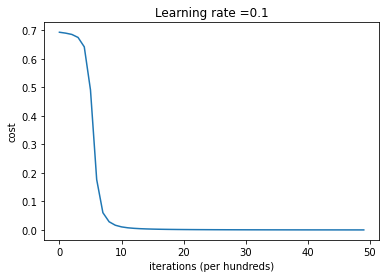

Erorr rate for training set ,SNR 18 dB = 0.0
Error rate for validation set ,SNR 18 dB = 0.0182370820668693


In [186]:
# write your own classification algorithm here

#first shape the data, convert input data from 128 complex number to 256 real number
#from 128 features to 256 features
X     = np.concatenate((X_train_task1.real,X_train_task1.imag),axis=1).transpose()
X     = X /X.max()                  #normalize the input training X.max()
X_val = np.concatenate((X_valid_task1.real,X_valid_task1.imag),axis=1).transpose()
X_val = X_val/X_val.max()           #normalize the input validation

Y     = np.equal(y_train_task1,4)   #set 0 as BPSK and 1 as GFSK
Y     = Y.astype(float)             #convert data type to float
Y     = Y.reshape(-1,1).transpose() #reshape the array
Y_val = np.equal(y_valid_task1,4)
Y_val = Y_val.astype(float)
Y_val = Y_val.reshape(-1,1).transpose()

X_train_SNR=[]
X_valid_SNR=[]
Y_train_SNR=[]
Y_valid_SNR=[]

#variables
alpha = 0.1                     #learning rate  
num_iteration = 5000               #number of iteration
layer_dims = [X.shape[0],64,32,16,1]          #4 layers model
#divide the data base on SNR
SNR_range = np.unique(SNR_train_task1) #range of SNR from -20 to 18dB
Error_rates = np.zeros(len(SNR_range)) #store the value of error rate for every SNR
Error_rates_train = np.zeros(len(SNR_range))

#loop over all SNR value
for idx,value in enumerate(SNR_range):
    #assign indices for every SNR value
    ids_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]
    ids_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    #divide data according to its SNR value
    X_train_SNR = X[:,ids_train]
    X_valid_SNR = X_val[:,ids_valid]
    Y_train_SNR = Y[:,ids_train]
    Y_valid_SNR = Y_val[:,ids_valid]
    
    
    #feed the data to Neural Network model
    params = deep_network_model(X_train_SNR,Y_train_SNR,layer_dims,alpha,num_iteration,True)
    #make a prediction    
    Y_pred_train = make_prediction(X_train_SNR,params)
    Y_pred = make_prediction(X_valid_SNR,params)    
    
    #calculate the error for every SNR value
    Error_rates_train[idx] = CER(Y_pred_train,Y_train_SNR)
    Error_rates[idx] = CER(Y_pred,Y_valid_SNR)
    
    
    print("Erorr rate for training set ,SNR "+str(value)+" dB = "+str(Error_rates_train[idx]))
    print("Error rate for validation set ,SNR "+str(value)+" dB = "+str(Error_rates[idx])) 
    '''
    print("X_val shape "+str(X_val.shape))
    print("length of ids_train "+str(len(ids_train)))
    print("length of ids_valid "+str(len(ids_valid)))
    print("X_train_SNR shape "+str(X_train_SNR.shape))
    print("Y_train_SNR shape "+str(Y_train_SNR.shape))
    print("Y_pred shape "+str(Y_pred.shape))
    print("X_valid_SNR "+str(X_valid_SNR.shape))
    print("Y_valid_SNR "+str(Y_valid_SNR.shape))      
    print("length of Y_pred "+str(np.size(Y_pred)))
    print("length of Y_valid_SNR "+str(np.size(Y_valid_SNR)))
    '''

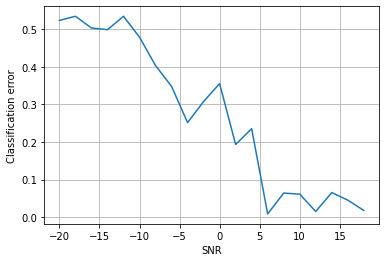

In [187]:
plt.figure(figsize=(6,4))
plt.plot(SNR_range, Error_rates)
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

In [ ]:


# prepare data, convert complex data to real and imaginary parts
X_train_real = np.column_stack((np.real(X_train_task1), np.imag(X_train_task1)))
X_valid_real = np.column_stack((np.real(X_valid_task1), np.imag(X_valid_task1)))


# generate 0/1 class labels
dic = {task1_modulation_formatidx[0]: 0, task1_modulation_formatidx[1]: 1}
y_train_mod = np.array([dic.get(i) for i in y_train_task1])
y_valid_mod = np.array([dic.get(i) for i in y_valid_task1])


SNR_range = np.unique(SNR_train_task1)
Error_rates = np.zeros(len(SNR_range))

# loop over SNRs
for idx, value in enumerate(SNR_range):
    # pick training and validation examples corresponding to specific SNR
    indices_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    indices_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]

    # dummy classifier ... return random numbers ... can you do betters?    
    valid_est = np.random.randint(low=0,high=2, size=y_valid_mod[indices_valid].shape)
   
    Error_rates[idx] = CER(valid_est, y_valid_mod[indices_valid])

plt.figure(figsize=(6,4))
plt.plot(SNR_range, Error_rates)
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

In [ ]:
# space where you can program your own (better) classifier






## Task 2: Classify modulation format
Design an ML system that estimates the modulation format from the traces (supervised learning, classification task). To evaluate the performance, carry out the classification separately for each SNR and show the performance for each SNR point.
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

## Task 2: Determine SNR
Determine the SNR from the examples (supervised learning, classification task)

## Task 3: Cluster the traces
Try if clustering is successful and if you can group examples that share similar properties (e.g., modulation format and SNR)